# **`EDA` y `ETL` inicial de los datos**

Los datos de conexiones a internet se tomaron de la web del enacom (dataset `Internet`)
[Datasets principales](https://indicadores.enacom.gob.ar/datos-abiertos)

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import warnings

In [2]:
# Cargar el archivo Excel
path = r'C:\Users\paula\OneDrive\Curso\Henry\Proyecto Individual\2da parte\Telecomunucaciones_AR\Datasets crudos\Internet.xlsx'
excel_data = pd.ExcelFile(path)

# Mostrar los nombres de las hojas disponibles
hojas = list(excel_data.sheet_names)
hojas

['Acc_vel_loc_sinrangos',
 'Velocidad_sin_Rangos',
 'Accesos_tecnologia_localidad',
 'Velocidad % por prov',
 'Totales VMD',
 'Totales Accesos Por Tecnología',
 'Accesos Por Tecnología',
 'Penetración-poblacion',
 'Penetracion-hogares',
 'Penetracion-totales',
 'Totales Accesos por rango',
 'Accesos por rangos',
 'Dial-BAf',
 'Totales Dial-BAf',
 'Ingresos ']

| DataFrame               | Contenido Principal                                          | ¿Usar? |
|-------------------------|-------------------------------------------------------------|--------|
| `acc_vel_loc_sinrangos` | Acceso a internet por localidad                             | Sí     |
| `vel_sin_rangos`        | Velocidad de acceso y cantidad por provincia                | No     |
| `acc_tec_localidad`     | Accesos por tecnología y por localidad                      | Sí     |
| `vel_porc_prov`         | Velocidad promedio por provincia por trimestre              | Sí     |
| `totales_VMD`           | Velocidad media por trimestre                               | No     |
| `totales_acc_tec`       | Accesos por tecnologías y por trimestre                     | No     |
| `acc_tec`               | Accesos por tecnologías, por trimestre y por provincia      | Sí     |
| `penetracion_pob`       | Accesos por cada 100 habitantes, por provincia y por trimestre | Sí     |
| `penetracion_hogares`   | Accesos por cada 100 hogares, por provincia y por trimestre | Sí     |
| `penetracion_totales`   | Accesos por cada 100 habitantes y 100 hogares por trimestre | No     |
| `totales_acc_rangos`    | Accesos por velocidad y por trimestre                       | No     |
| `acc_rangos`            | Accesos por velocidad, por provincia y por trimestre        | Sí     |
| `dial_baf`              | Tipo de conexión por provincia y por trimestre              | Sí     |
| `totales_dial_baf`      | Tipo de conexión por trimestre                              | No     |
| `ingresos`              | Ingresos en $ por trimestre                                 | No     |


## Procesamiento del df `acc_vel_loc_sinrangos`

In [3]:
acc_vel_loc_sinrangos = pd.read_excel(path, sheet_name='Acc_vel_loc_sinrangos')

In [4]:
acc_vel_loc_sinrangos.head() 

,Partido,Localidad,link Indec,Velocidad (Mbps),Provincia,Accesos
0,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,0.00,1.0
1,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,0.50,2.0
2,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,0.75,19.0
3,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,3.00,85.0
4,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,3.50,145.0


Acá hay un error en los encabezados. El orden correcto, por los datos de las columnas, debería ser:<br>
`Provincia` | `Partido` | `Localidad`	| `link Indec` | `Velocidad (Mbps)`	| `Accesos` 

In [5]:
# Renombrar las columnas
acc_vel_loc_sinrangos.rename(columns={
    'Partido': 'Provincia',
    'Localidad': 'Partido',
    'link Indec': 'Localidad',
    'Velocidad (Mbps)': 'link Indec',
    'Provincia': 'Velocidad (Mbps)',
    'Accesos': 'Accesos'
}, inplace=True)

acc_vel_loc_sinrangos.head() 

,Provincia,Partido,Localidad,link Indec,Velocidad (Mbps),Accesos
0,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,0.00,1.0
1,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,0.50,2.0
2,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,0.75,19.0
3,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,3.00,85.0
4,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,3.50,145.0


Los análisis se harán en base a las provincias, por lo tanto no se usaran ni los datos de partido, ni localidad ni link del indec. Por lo tanto los valores se agrupan por provincia y por velocidad

In [6]:
acc_vel_loc_sinrangos = acc_vel_loc_sinrangos.drop(columns=['Partido', 'Localidad', 'link Indec'])
acc_vel_loc_sinrangos = acc_vel_loc_sinrangos.groupby(['Provincia', 'Velocidad (Mbps)'], as_index=False).sum()

In [7]:
acc_vel_loc_sinrangos.info()
acc_vel_loc_sinrangos.describe()
acc_vel_loc_sinrangos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Provincia         874 non-null    object 
 1   Velocidad (Mbps)  874 non-null    float64
 2   Accesos           874 non-null    float64
dtypes: float64(2), object(1)
memory usage: 20.6+ KB


,Provincia,Velocidad (Mbps),Accesos
0,BUENOS AIRES,0.000,125547.0
1,BUENOS AIRES,0.256,25.0
2,BUENOS AIRES,0.500,25048.0
3,BUENOS AIRES,0.512,214.0
4,BUENOS AIRES,0.750,4611.0
...,...,...,...
869,TUCUMAN,200.000,1.0
870,TUCUMAN,300.000,45438.0
871,TUCUMAN,500.000,2471.0
872,TUCUMAN,600.000,2285.0


### Normalizar la columna `Provincia`

In [8]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
acc_vel_loc_sinrangos['Provincia'] = acc_vel_loc_sinrangos['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
acc_vel_loc_sinrangos['Provincia'] = acc_vel_loc_sinrangos['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(acc_vel_loc_sinrangos['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


Creo que esta es información redundante con respecto a los accesos por rangos.

## Procesamiento del df `vel_sin_rangos`

In [9]:
vel_sin_rangos = pd.read_excel(path, sheet_name='Velocidad_sin_Rangos')

In [10]:
vel_sin_rangos.head()

,Año,Trimestre,Provincia,Velocidad,Accesos
0,2024,2,BUENOS AIRES,75.0,1062
1,2024,2,BUENOS AIRES,59.0,59
2,2024,2,BUENOS AIRES,480.0,5
3,2024,2,BUENOS AIRES,3.5,41735
4,2024,2,BUENOS AIRES,18.0,1042


In [11]:
vel_sin_rangos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18884 entries, 0 to 18883
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Año        18884 non-null  int64  
 1   Trimestre  18884 non-null  int64  
 2   Provincia  18884 non-null  object 
 3   Velocidad  18874 non-null  float64
 4   Accesos    18884 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 737.8+ KB


La única columna que tiene valores nulos es `Velocidad`

In [12]:
# Filtrar registros con Velocidad nula
vel_sin_rangos_nulos = vel_sin_rangos[vel_sin_rangos['Velocidad'].isnull()]
print(vel_sin_rangos_nulos)

        Año  Trimestre     Provincia  Velocidad  Accesos
1155   2024          1       Córdoba        NaN        1
1644   2024          1      Santa Fe        NaN        9
3753   2023          2       Córdoba        NaN        1
4239   2023          2      Santa Fe        NaN        9
6303   2022          3       Córdoba        NaN        1
6785   2022          3      Santa Fe        NaN        9
9255   2021          3  Buenos Aires        NaN        4
10031  2021          2  Buenos Aires        NaN        4
10794  2021          1  Buenos Aires        NaN        4
11538  2020          4  Buenos Aires        NaN        4


In [13]:
vel_sin_rangos.describe()

,Año,Trimestre,Velocidad,Accesos
count,18884.000000,18884.000000,18874.000000,1.888400e+04
mean,2021.017104,2.477653,96.171156,1.412328e+04
std,1.919740,1.126947,379.722905,6.856387e+04
min,2017.000000,1.000000,0.000000,0.000000e+00
25%,2019.000000,1.000000,4.000000,2.600000e+01
50%,2021.000000,2.000000,12.300000,6.725000e+02
75%,2023.000000,4.000000,50.100000,6.114000e+03
max,2024.000000,4.000000,10000.000000,1.346370e+06


Se ve que `Velocidad` tiene una dispersión importante de los valores, por lo que se analiza su distribución

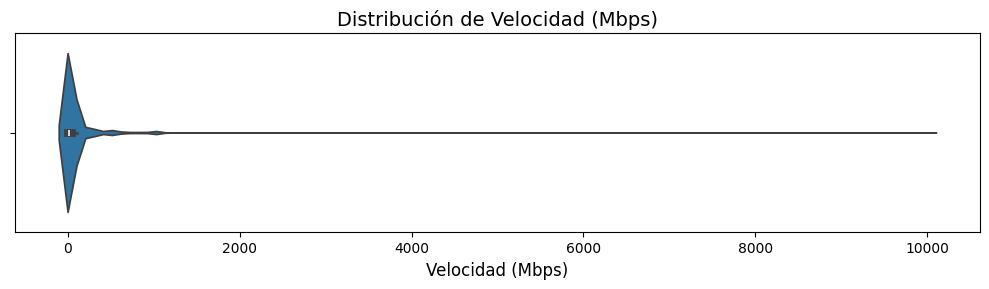

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 3))

# Crear el gráfico de violines
sns.violinplot(x=vel_sin_rangos['Velocidad'])

# Agregar título y etiquetas
plt.title('Distribución de Velocidad (Mbps)', fontsize=14)
plt.xlabel('Velocidad (Mbps)', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Un poquito de contexto
>En Argentina, la velocidad máxima de internet disponible para usuarios residenciales varía según el proveedor y la tecnología utilizada. Por ejemplo, Telecentro ofrece planes de hasta 1000 megas con WiFi 6, asegurando una conexión estable y ultrarrápida. [1](https://telecentro.com.ar/internet)
>
>Por otro lado, Claro Argentina ofrece planes de fibra óptica con velocidades de hasta 600 megas. [2](https://www.claro.com.ar/personas/internet-wifi-telefonia-tv) 
>
>Es importante destacar que la velocidad real experimentada por los usuarios puede variar debido a factores como la infraestructura local, la congestión de la red y la calidad del equipo utilizado.
>
>A nivel internacional, según datos de noviembre de 2024, Argentina registró una velocidad promedio de descarga de internet de banda ancha fija de 92.62 Mbps, ubicándose en el puesto 58 a nivel mundial. [3](https://es.wikipedia.org/wiki/Anexo%3AVelocidad_de_conexi%C3%B3n_a_Internet_por_pa%C3%ADses)
>
>En resumen, aunque algunos proveedores en Argentina ofrecen planes de hasta 1000 megas, la velocidad promedio de descarga en el país es significativamente menor, y la velocidad máxima disponible para usuarios residenciales puede variar según el proveedor y la ubicación.

Dado estos datos, se van a marcar como outliers los registros con velocidades mayores a la `media +/- 3*std`, y probablemente dejados fuera en los análisis.

In [15]:
vel_mean = vel_sin_rangos['Velocidad'].mean()
vel_std = vel_sin_rangos['Velocidad'].std()

vel_max = vel_mean + 3*vel_std

In [16]:
# Crear la nueva columna 'es_outlier'
vel_sin_rangos['es_outlier'] = vel_sin_rangos['Velocidad'] > vel_max

# Verificar el resultado
print(vel_sin_rangos.head())

    Año  Trimestre     Provincia  Velocidad  Accesos  es_outlier
0  2024          2  BUENOS AIRES       75.0     1062       False
1  2024          2  BUENOS AIRES       59.0       59       False
2  2024          2  BUENOS AIRES      480.0        5       False
3  2024          2  BUENOS AIRES        3.5    41735       False
4  2024          2  BUENOS AIRES       18.0     1042       False


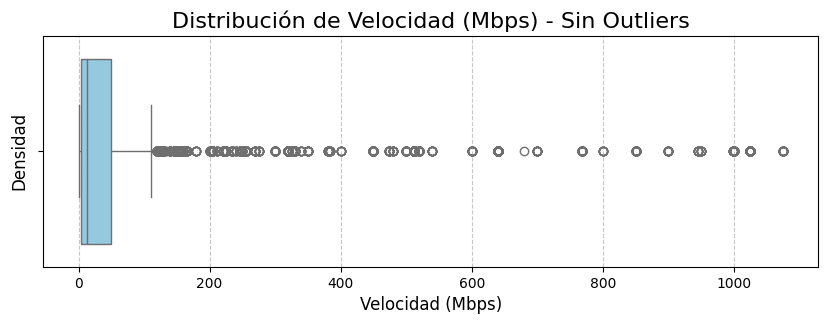

In [17]:
# Filtrar valores de velocidad para excluir outliers
vel_filtrada = vel_sin_rangos[vel_sin_rangos['Velocidad'] <= vel_max]

# Crear el gráfico de violines con los datos filtrados
plt.figure(figsize=(10, 3))
sns.boxplot(x=vel_filtrada['Velocidad'], color="skyblue")

# Configurar título y etiquetas
plt.title('Distribución de Velocidad (Mbps) - Sin Outliers', fontsize=16)
plt.xlabel('Velocidad (Mbps)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)

# Mostrar el gráfico
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [18]:
vel_sin_rangos['es_outlier'].value_counts()

es_outlier
False    18790
True        94
Name: count, dtype: int64

Finalmente los outliers resultaron ser solo 94 registros. Por lo tanto, los marco como outlier pero no los borro

In [19]:
# Filtrar registros donde es_outlier es False
no_outliers = vel_sin_rangos[vel_sin_rangos['es_outlier'] == False]

no_outliers.describe()

,Año,Trimestre,Velocidad,Accesos
count,18790.000000,18790.000000,18780.000000,1.879000e+04
mean,2021.018467,2.477222,75.657529,1.419362e+04
std,1.923888,1.126983,174.074725,6.872794e+04
min,2017.000000,1.000000,0.000000,0.000000e+00
25%,2019.000000,1.000000,4.000000,2.700000e+01
50%,2021.000000,2.000000,12.300000,6.930000e+02
75%,2023.000000,4.000000,50.100000,6.172000e+03
max,2024.000000,4.000000,1075.000000,1.346370e+06


#### Recálculo de las estadísticas de velocidad y nuevo gráfico. (*solo a fines de visualización*) 

In [20]:
no_outliers_mean = no_outliers['Velocidad'].mean()
no_outliers_std = no_outliers['Velocidad'].std()

no_outliers_max = no_outliers_mean + 3*no_outliers_std
print(no_outliers_max)

597.8817032387927


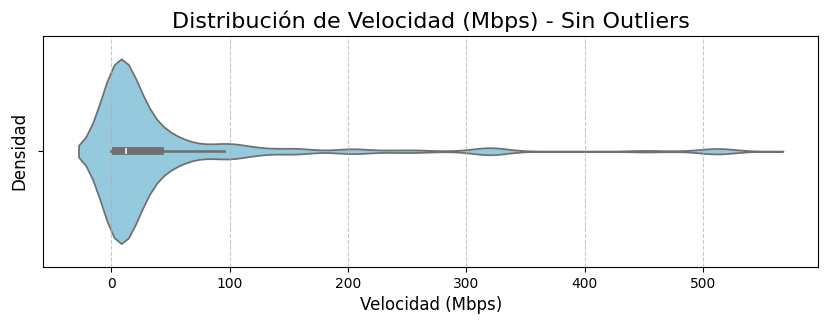

In [21]:
# Filtrar valores de velocidad para excluir outliers
no_outliers_filtrada = no_outliers[no_outliers['Velocidad'] <= no_outliers_max]

# Crear el gráfico de violines con los datos filtrados
plt.figure(figsize=(10, 3))
sns.violinplot(x=no_outliers_filtrada['Velocidad'], color="skyblue")

# Configurar título y etiquetas
plt.title('Distribución de Velocidad (Mbps) - Sin Outliers', fontsize=16)
plt.xlabel('Velocidad (Mbps)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)

# Mostrar el gráfico
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

El gráfico de violines muestra la distribución de las velocidades de internet en Mbps después de filtrar los valores extremos (outliers mayores a 597.8 Mbps). Algunas observaciones clave y posibles conclusiones:

**Concentración en velocidades bajas:** La mayor densidad de velocidades se encuentra en valores bajos, cercanos a 0 Mbps. Esto podría reflejar que una gran proporción de los accesos tiene velocidades lentas, lo cual podría ser común en algunas áreas geográficas o segmentos del mercado.

**Cola alargada:** Aunque menos frecuentes, hay velocidades más altas presentes (por ejemplo, entre 100 Mbps y 500 Mbps). Estas podrían corresponder a lugares altamente poblados (grandes ciudades), accesos más modernos, como fibra óptica, en áreas mejor conectadas o servicios premium.

**Distribución asimétrica:** La asimetría indica que el acceso a velocidades altas no es uniforme y está limitado a pocos casos, lo que podría señalar desigualdades en la oferta de servicios de internet.

##### **Posibles Conclusiones:**
**Brecha digital:** La mayoría de los usuarios aún no tiene acceso a velocidades altas de internet, lo que podría ser un área de mejora para políticas públicas o estrategias comerciales.
**Evidencia de segmentación del mercado:** Hay presencia de velocidades altas, pero en menor densidad, lo que indica que estas pueden estar limitadas a ciertos sectores privilegiados.

Los nulos para la velocidad, que son pocos, se imputan como el promedio de la velocidad para el trimestre y la provincia, para mantener las tendencias en el tiempo por provincias.
Además hay uns dispersión en los nommbres de las provincias que hay que normalizar

### Normalización de la columna `Provincia`

In [22]:
print(vel_sin_rangos['Provincia'].unique())

['BUENOS AIRES' 'CABA' 'CATAMARCA' 'CHACO' 'CHUBUT' 'CORDOBA' 'CORRIENTES'
 'ENTRE RIOS' 'FORMOSA' 'JUJUY' 'LA PAMPA' 'LA RIOJA' 'MENDOZA' 'MISIONES'
 'NEUQUEN' 'RIO NEGRO' 'SALTA' 'SAN JUAN' 'SAN LUIS' 'SANTA CRUZ'
 'SANTA FE' 'SANTIAGO DEL ESTERO' 'TIERRA DEL FUEGO' 'TUCUMAN'
 'Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Córdoba'
 'Corrientes' 'Entre Ríos' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquén' 'Río Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucumán']


In [23]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
vel_sin_rangos['Provincia'] = vel_sin_rangos['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
vel_sin_rangos['Provincia'] = vel_sin_rangos['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(vel_sin_rangos['Provincia'].unique())


['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


#### Imputación de nulos en `Velocidad`

In [24]:
# Calcular el promedio de velocidad por Provincia y Trimestre
promedios = vel_sin_rangos.groupby(['Provincia', 'Año', 'Trimestre'])['Velocidad'].mean()

# Imputar valores nulos en la columna Velocidad
vel_sin_rangos['Velocidad'] = vel_sin_rangos.apply(
    lambda row: promedios.loc[row['Provincia'], row['Año'], row['Trimestre']] 
    if pd.isnull(row['Velocidad']) else row['Velocidad'], axis=1
)

- *Probando si tiene la misma informacion que el df `acc_rangos`*

In [25]:
# Definir los rangos de velocidad y las etiquetas (ajustar etiquetas)
rangos = [0, 0.5, 1, 6, 10, 20, 30, np.inf]
etiquetas = [
    'HASTA 512 kbps', 
    '+ 512 Kbps - 1 Mbps', 
    '+ 1 Mbps - 6 Mbps', 
    '+ 6 Mbps - 10 Mbps', 
    '+ 10 Mbps - 20 Mbps', 
    '+ 20 Mbps - 30 Mbps', 
    '+ 30 Mbps'
]

# Crear una columna adicional para clasificar cada fila en un rango
vel_sin_rangos['Rango'] = pd.cut(vel_sin_rangos['Velocidad'], bins=rangos, labels=etiquetas, right=False)

# Agrupar por Año, Trimestre, Provincia y Rango para sumar los accesos
nuevo_df_rangos = vel_sin_rangos.groupby(['Año', 'Trimestre', 'Provincia', 'Rango'], observed=True)['Accesos'].sum().reset_index()

# Reorganizar el DataFrame para que los rangos sean columnas
nuevo_df_rangos = nuevo_df_rangos.pivot(index=['Año', 'Trimestre', 'Provincia'], columns='Rango', values='Accesos').reset_index()

# Llenar los valores NaN con 0 (por si alguna combinación no tuvo datos en un rango específico)
nuevo_df_rangos = nuevo_df_rangos.fillna(0)

In [26]:
nuevo_df_rangos

Rango,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps
0,2017,4,Buenos Aires,114182.0,3865.0,255783.0,1364301.0,788170.0,328869.0,333162.0
1,2017,4,Capital Federal,0.0,314.0,39191.0,510179.0,615511.0,242727.0,176316.0
2,2017,4,Catamarca,2151.0,34.0,3423.0,15074.0,5906.0,2925.0,45.0
3,2017,4,Chaco,1035.0,70.0,11334.0,38159.0,24441.0,17499.0,3933.0
4,2017,4,Chubut,0.0,67.0,21972.0,68560.0,2819.0,3.0,11.0
...,...,...,...,...,...,...,...,...,...,...
643,2024,2,Santa Cruz,33794.0,265.0,5980.0,4368.0,13477.0,7618.0,17959.0
644,2024,2,Santa Fe,28738.0,444.0,58102.0,38666.0,153395.0,47529.0,604099.0
645,2024,2,Santiago Del Estero,892.0,1086.0,7520.0,3027.0,57656.0,18980.0,36153.0
646,2024,2,Tierra Del Fuego,7124.0,340.0,6563.0,12140.0,12139.0,16789.0,6314.0


In [27]:
nuevo_df_rangos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Año                  648 non-null    int64  
 1   Trimestre            648 non-null    int64  
 2   Provincia            648 non-null    object 
 3   HASTA 512 kbps       648 non-null    float64
 4   + 512 Kbps - 1 Mbps  648 non-null    float64
 5   + 1 Mbps - 6 Mbps    648 non-null    float64
 6   + 6 Mbps - 10 Mbps   648 non-null    float64
 7   + 10 Mbps - 20 Mbps  648 non-null    float64
 8   + 20 Mbps - 30 Mbps  648 non-null    float64
 9   + 30 Mbps            648 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 50.8+ KB


### Evaluación del tiempo registrado en el df

In [28]:
# Ordenar por Año y Trimestre para garantizar el orden cronológico
vel_sin_rangos_sorted = vel_sin_rangos.sort_values(by=['Año', 'Trimestre'])

# Obtener el primer registro (inicio del rango de tiempo)
primer_trimestre = vel_sin_rangos_sorted.iloc[0]

# Obtener el último registro (fin del rango de tiempo)
ultimo_trimestre = vel_sin_rangos_sorted.iloc[-1]

# Mostrar los resultados
print("Primer trimestre registrado:")
print(primer_trimestre[['Año', 'Trimestre']])
print("\nÚltimo trimestre registrado:")
print(ultimo_trimestre[['Año', 'Trimestre']])

Primer trimestre registrado:
Año          2017
Trimestre       4
Name: 18437, dtype: object

Último trimestre registrado:
Año          2024
Trimestre       2
Name: 873, dtype: object


Este df tiene la misma información que `acc_rangos`, pero en un rango menor de tiempo, por lo tanto me quedo con `acc_rangos`.
Igualmente me sirven los datos para imputar faltantes/nulos en el df `acc_rangos`

# Procesamiento del df `acc_tec_localidad`

In [29]:
acc_tec_localidad = pd.read_excel(path, sheet_name='Accesos_tecnologia_localidad')

In [30]:
acc_tec_localidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7753 entries, 0 to 7752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Provincia   7753 non-null   object 
 1   Partido     7753 non-null   object 
 2   Localidad   7753 non-null   object 
 3   Tecnologia  7753 non-null   object 
 4   Link Indec  7753 non-null   object 
 5   Accesos     7747 non-null   float64
dtypes: float64(1), object(5)
memory usage: 363.6+ KB


In [31]:
acc_tec_localidad.head()

,Provincia,Partido,Localidad,Tecnologia,Link Indec,Accesos
0,BUENOS AIRES,25 de Mayo,25 de Mayo,ADSL,6854100,755.0
1,BUENOS AIRES,25 de Mayo,25 de Mayo,CABLEMODEM,6854100,4600.0
2,BUENOS AIRES,25 de Mayo,25 de Mayo,FIBRA OPTICA,6854100,2.0
3,BUENOS AIRES,25 de Mayo,25 de Mayo,SATELITAL,6854100,742.0
4,BUENOS AIRES,25 de Mayo,25 de Mayo,WIRELESS,6854100,727.0


In [32]:
acc_tec_localidad.describe()

,Accesos
count,7.747000e+03
mean,1.491688e+03
std,1.520174e+04
min,0.000000e+00
25%,3.000000e+00
50%,5.900000e+01
75%,4.005000e+02
max,1.144781e+06


Los análisis se harán en base a las provincias, por lo tanto no se usaran ni los datos de `Partido`, ni `Localidad` ni `Link Indec`. Por lo tanto los valores se agrupan por `Provincia` y por `Tecnologia`

In [33]:
acc_tec_localidad = acc_tec_localidad.drop(columns=['Partido', 'Localidad', 'Link Indec'])
acc_tec_localidad = acc_tec_localidad.groupby(['Provincia', 'Tecnologia'], as_index=False).sum()

In [34]:
acc_tec_localidad.info()
acc_tec_localidad.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Provincia   176 non-null    object 
 1   Tecnologia  176 non-null    object 
 2   Accesos     176 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.3+ KB


,Provincia,Tecnologia,Accesos
0,BUENOS AIRES,ADSL,214055.0
1,BUENOS AIRES,CABLEMODEM,2519875.0
2,BUENOS AIRES,Cablemodem,202591.0
3,BUENOS AIRES,DIAL UP,5900.0
4,BUENOS AIRES,FIBRA OPTICA,1849476.0


In [35]:
acc_tec_localidad['Tecnologia'].value_counts()

Tecnologia
ADSL            24
CABLEMODEM      24
FIBRA OPTICA    24
SATELITAL       24
WIRELESS        24
DIAL UP         21
Otros           21
OTROS            8
WIMAX            5
Cablemodem       1
Name: count, dtype: int64

In [36]:
tecnologia_filtrada = acc_tec_localidad[acc_tec_localidad['Tecnologia'] == 'OTROS']
print(tecnologia_filtrada)

            Provincia Tecnologia  Accesos
5        BUENOS AIRES      OTROS   7442.0
14               CABA      OTROS  27704.0
50         CORRIENTES      OTROS      1.0
59         ENTRE RIOS      OTROS      2.0
143        SANTA CRUZ      OTROS    406.0
150          SANTA FE      OTROS    152.0
165  TIERRA DEL FUEGO      OTROS      4.0
172           TUCUMAN      OTROS      1.0


In [37]:
# Unificar "CABLEMODEM" y "Cablemodem" en "CABLEMODEM"
acc_tec_localidad['Tecnologia'] = acc_tec_localidad['Tecnologia'].replace(
    ['Cablemodem', 'CABLEMODEM'], 'CABLEMODEM'
)

# Unificar "OTROS" y "Otros" en "OTROS"
acc_tec_localidad['Tecnologia'] = acc_tec_localidad['Tecnologia'].replace(
    ['Otros', 'OTROS'], 'OTROS'
)

**WiMAX** (Worldwide Interoperability for Microwave Access) es una tecnología de acceso inalámbrico de banda ancha que permite transmitir datos a alta velocidad sobre largas distancias. Dado que son pocos los registros, lo unifico con `WIRELESS`

In [38]:
# Unificar "WIRELESS" y "Cablemodem" en "WIRELESS"
acc_tec_localidad['Tecnologia'] = acc_tec_localidad['Tecnologia'].replace(
    ['WIMAX', 'WIRELESS'], 'WIRELESS'
)

In [39]:
# Agrupar por Provincia y Tecnologia, sumando los valores de Accesos
acc_tec_localidad = acc_tec_localidad.groupby(['Provincia', 'Tecnologia'], as_index=False)['Accesos'].sum()

In [40]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
acc_tec_localidad['Provincia'] = acc_tec_localidad['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
acc_tec_localidad['Provincia'] = acc_tec_localidad['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(acc_tec_localidad['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


In [41]:
acc_tec_localidad.to_csv(r'C:\Users\paula\OneDrive\Curso\Henry\Proyecto Individual\2da parte\Telecomunucaciones_AR\Datasets procesados\acc_tec_localidad_limpio.csv', index=False)

# Procesamiento del df `totales_acc_tec`

In [42]:
totales_acc_tec = pd.read_excel(path, sheet_name='Totales Accesos Por Tecnología')

In [43]:
totales_acc_tec.head()

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Periodo
0,2024,2,733491,5867504,4169958,593197,191957,11556107,Abr-Jun 2024
1,2024,1,774475,5986957,4015101,598682,257941,11633156,Ene-Mar 2024
2,2023,4,836390,6022532,3908183,585760,194796,11547661,Oct-Dic 2023
3,2023,3,897895,6018832,3708718,581436,200027,11406908,Jul-Sept 2023
4,2023,2,1006509,5997149,3463988,581823,202428,11251897,Abr-Jun 2023


In [44]:
# Eliminar la columna 'Periodo'
totales_acc_tec = totales_acc_tec.drop(columns=['Periodo'])

# Verificar el resultado
totales_acc_tec.head()

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2024,2,733491,5867504,4169958,593197,191957,11556107
1,2024,1,774475,5986957,4015101,598682,257941,11633156
2,2023,4,836390,6022532,3908183,585760,194796,11547661
3,2023,3,897895,6018832,3708718,581436,200027,11406908
4,2023,2,1006509,5997149,3463988,581823,202428,11251897


In [45]:
totales_acc_tec.to_csv(r'C:\Users\paula\OneDrive\Curso\Henry\Proyecto Individual\2da parte\Telecomunucaciones_AR\Datasets procesados\totales_acc_tec_limpio.csv', index=False)

# Procesamiento del df `vel_por_prov`

In [46]:
vel_por_prov = pd.read_excel(path, sheet_name='Velocidad % por prov')

In [47]:
vel_por_prov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año                     1008 non-null   int64  
 1   Trimestre               1008 non-null   int64  
 2   Provincia               1008 non-null   object 
 3   Mbps (Media de bajada)  1008 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.6+ KB


In [48]:
vel_por_prov.head()

,Año,Trimestre,Provincia,Mbps (Media de bajada)
0,2024,2,Buenos Aires,157.41
1,2024,2,Capital Federal,233.01
2,2024,2,Catamarca,97.38
3,2024,2,Chaco,107.76
4,2024,2,Chubut,21.67


In [49]:
vel_por_prov.describe()

,Año,Trimestre,Mbps (Media de bajada)
count,1008.000000,1008.000000,1008.000000
mean,2018.761905,2.452381,24.720245
std,3.039439,1.117574,33.660764
min,2014.000000,1.000000,2.573729
25%,2016.000000,1.000000,4.866698
50%,2019.000000,2.000000,10.089315
75%,2021.000000,3.000000,29.875292
max,2024.000000,4.000000,234.440000


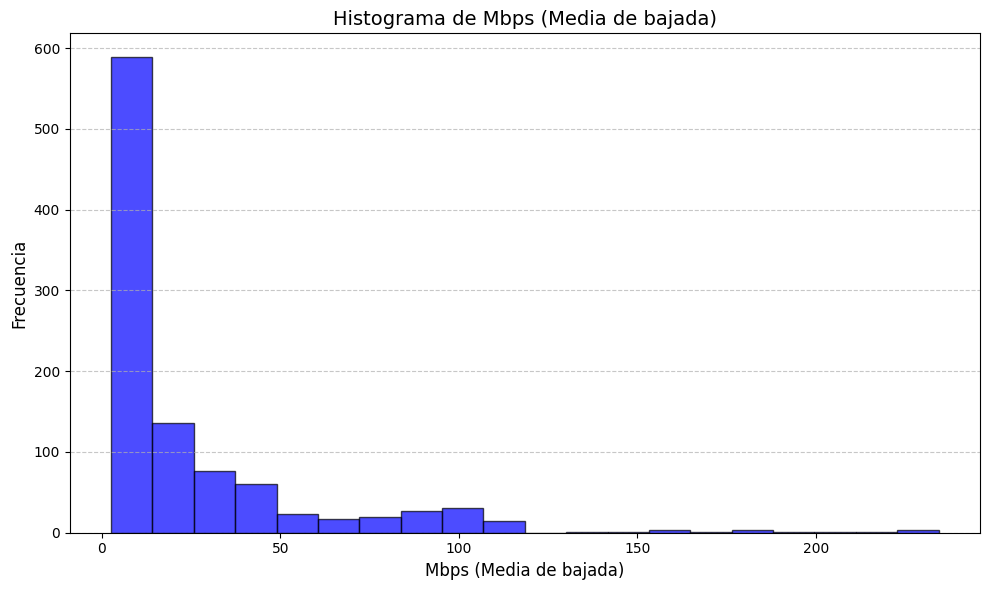

In [50]:
import matplotlib.pyplot as plt

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(vel_por_prov['Mbps (Media de bajada)'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma de Mbps (Media de bajada)', fontsize=14)
plt.xlabel('Mbps (Media de bajada)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [51]:
# Obtener el top 10 de las mayores velocidades
top_10_mbps = vel_por_prov.nlargest(10, 'Mbps (Media de bajada)')

# Mostrar los resultados
print(top_10_mbps)

      Año  Trimestre        Provincia  Mbps (Media de bajada)
49   2023          4  Capital Federal                  234.44
1    2024          2  Capital Federal                  233.01
25   2024          1  Capital Federal                  229.94
73   2023          3  Capital Federal                  218.13
97   2023          2  Capital Federal                  208.01
121  2023          1  Capital Federal                  188.65
145  2022          4  Capital Federal                  182.86
18   2024          2         San Luis                  181.61
42   2024          1         San Luis                  179.49
66   2023          4         San Luis                  174.59


In [52]:
# Obtener el bottom 10 de las mayores velocidades
bottom_10_mbps = vel_por_prov.nsmallest(10, 'Mbps (Media de bajada)')

# Mostrar los resultados
print(bottom_10_mbps)

      Año  Trimestre  Provincia  Mbps (Media de bajada)
992  2014          1    Formosa                2.573729
994  2014          1   La Pampa                2.647210
968  2014          2    Formosa                2.652351
944  2014          3    Formosa                2.656283
970  2014          2   La Pampa                2.684576
993  2014          1      Jujuy                2.690263
922  2014          4   La Pampa                2.754209
969  2014          2      Jujuy                2.769032
986  2014          1  Catamarca                2.802734
946  2014          3   La Pampa                2.816520


**Velocidades más altas (Top 10)**
1. Todas las velocidades más altas corresponden a los años 2023 y 2024, con Capital Federal y San Luis liderando los promedios, superando los 170 Mbps.
2. Esto muestra una clara evolución en la infraestructura tecnológica en los últimos años, probablemente debido a:
    - La implementación más amplia de fibra óptica y cablemodem.
    - La creciente demanda de conexiones de alta velocidad para actividades como streaming, trabajo remoto y educación virtual.
    - Políticas gubernamentales o privadas enfocadas en mejorar la conectividad en ciertas provincias.


**Velocidades más bajas (Bottom 10)**
1. Las velocidades más bajas corresponden al año 2014, con valores entre 2.5 Mbps y 2.8 Mbps, en provincias como Formosa, La Pampa, Jujuy y Catamarca.
2. Esto sugiere que estas regiones:
    - Dependían principalmente de tecnologías obsoletas como ADSL o Wireless.
    - No habían recibido suficiente inversión para modernizar la infraestructura en esa época.
    - Es importante destacar que el bajo nivel de acceso en 2014 es coherente con el contexto tecnológico del país en ese momento, cuando la conectividad de alta velocidad no estaba tan extendida.

**Comparación Temporal**
1. En menos de una década, las velocidades promedio han mejorado drásticamente en varias provincias, especialmente en las más conectadas, como Capital Federal.
2. Sin embargo, la evolución no ha sido homogénea. Se deben hacer análisis adicionales ya que es crucial identificar si aún persiste una brecha digital significativa en estas regiones.

**Conclusión General**
* El análisis muestra un avance importante en las velocidades promedio de internet en Argentina entre 2014 y 2024, pero con una evolución desigual.
* Las provincias más urbanizadas y económicamente activas, como Capital Federal, lideran la modernización, mientras que las provincias históricamente más rezagadas podrían seguir enfrentando desafíos.
* Es necesario monitorear el progreso en regiones históricamente más lentas, como Formosa y Jujuy, para garantizar que las mejoras en conectividad sean equitativas.

In [53]:
vel_por_prov['Año'].value_counts()

Año
2023    96
2022    96
2021    96
2017    96
2020    96
2019    96
2018    96
2015    96
2016    96
2014    96
2024    48
Name: count, dtype: int64

In [54]:
vel_por_prov['Trimestre'].value_counts()

Trimestre
2    264
1    264
4    240
3    240
Name: count, dtype: int64

In [55]:
vel_por_prov['Provincia'].value_counts()

Provincia
Buenos Aires           42
Capital Federal        42
Catamarca              42
Chaco                  42
Chubut                 42
Córdoba                42
Corrientes             42
Entre Ríos             42
Formosa                42
Jujuy                  42
La Pampa               42
La Rioja               42
Mendoza                42
Misiones               42
Neuquén                42
Río Negro              42
Salta                  42
San Juan               42
San Luis               42
Santa Cruz             42
Santa Fe               42
Santiago Del Estero    42
Tierra Del Fuego       42
Tucumán                42
Name: count, dtype: int64

### Normalizar la columna `Provincia`

In [56]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
vel_por_prov['Provincia'] = vel_por_prov['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
vel_por_prov['Provincia'] = vel_por_prov['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(vel_por_prov['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


In [57]:
# Ordenar por Año y Trimestre para garantizar el orden cronológico
vel_porc_prov_sorted = vel_por_prov.sort_values(by=['Año', 'Trimestre'])

# Obtener el primer registro (inicio del rango de tiempo)
primer_trimestre = vel_porc_prov_sorted.iloc[0]

# Obtener el último registro (fin del rango de tiempo)
ultimo_trimestre = vel_porc_prov_sorted.iloc[-1]

# Mostrar los resultados
print("Primer trimestre registrado:")
print(primer_trimestre[['Año', 'Trimestre']])
print("\nÚltimo trimestre registrado:")
print(ultimo_trimestre[['Año', 'Trimestre']])

Primer trimestre registrado:
Año          2014
Trimestre       1
Name: 984, dtype: object

Último trimestre registrado:
Año          2024
Trimestre       2
Name: 23, dtype: object


# Procesamiento del df `acc_tec`

In [58]:
acc_tec = pd.read_excel(path, sheet_name='Accesos Por Tecnología')

In [59]:
acc_tec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Año           1008 non-null   object 
 1   Trimestre     1008 non-null   object 
 2   Provincia     1007 non-null   object 
 3   ADSL          1007 non-null   float64
 4   Cablemodem    1007 non-null   float64
 5   Fibra óptica  1007 non-null   float64
 6   Wireless      1007 non-null   float64
 7   Otros         1007 non-null   float64
 8   Total         1007 non-null   float64
dtypes: float64(6), object(3)
memory usage: 71.1+ KB


In [60]:
# Filtrar registros que tengan valores nulos en las columnas indicadas
nulos_acc_tec = acc_tec[
    acc_tec[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros', 'Total']].isnull().any(axis=1)
]

# Mostrar los registros nulos
nulos_acc_tec

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,*,Los datos provinciales no coinciden a nivel na...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# Eliminar filas con valores nulos en las columnas especificadas
acc_tec = acc_tec.dropna(subset=['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros', 'Total'])

In [62]:
acc_tec.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, 0 to 1006
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Año           1007 non-null   object 
 1   Trimestre     1007 non-null   object 
 2   Provincia     1007 non-null   object 
 3   ADSL          1007 non-null   float64
 4   Cablemodem    1007 non-null   float64
 5   Fibra óptica  1007 non-null   float64
 6   Wireless      1007 non-null   float64
 7   Otros         1007 non-null   float64
 8   Total         1007 non-null   float64
dtypes: float64(6), object(3)
memory usage: 78.7+ KB


In [63]:
acc_tec.head()

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2024,2,Buenos Aires,214055.0,2722466.0,1849476.0,138638.0,64745.0,4989380.0
1,2024,2,Capital Federal,54102.0,1144781.0,230402.0,4493.0,29821.0,1463599.0
2,2024,2,Catamarca,4951.0,10303.0,58355.0,1384.0,81.0,75074.0
3,2024,2,Chaco,9448.0,57935.0,68944.0,8407.0,2358.0,147092.0
4,2024,2,Chubut,25955.0,80704.0,26516.0,31118.0,9930.0,174223.0


In [64]:
print(acc_tec['Año'].value_counts())
print(acc_tec['Trimestre'].value_counts())
print(acc_tec['Provincia'].value_counts())

Año
2023      96
2022      96
2021      96
2020      96
2015      96
2018      96
2016      96
2017      96
2014      96
2019 *    72
2024      47
2019      24
Name: count, dtype: int64
Trimestre
2      240
4      240
1      239
3      216
3 *     24
2 *     24
1 *     24
Name: count, dtype: int64
Provincia
Capital Federal        42
Catamarca              42
Chaco                  42
Chubut                 42
Corrientes             42
Córdoba                42
Entre Ríos             42
Formosa                42
Salta                  42
Jujuy                  42
La Pampa               42
La Rioja               42
Mendoza                42
Misiones               42
Neuquén                42
Río Negro              42
Santa Fe               42
San Juan               42
San Luis               42
Santa Cruz             42
Tierra Del Fuego       42
Santiago Del Estero    42
Tucumán                42
Buenos Aires           41
Name: count, dtype: int64


In [65]:
acc_tec['Año'] = acc_tec['Año'].astype(str).str.replace(' *', '').astype(int)
acc_tec['Trimestre'] = acc_tec['Trimestre'].astype(str).str.replace(' *', '').astype(int)

### Noramlizar la columna `Provincia`

In [66]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
acc_tec['Provincia'] = acc_tec['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
acc_tec['Provincia'] = acc_tec['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(vel_por_prov['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


In [67]:
# Ordenar por Año y Trimestre para garantizar el orden cronológico
acc_tec_sorted = acc_tec.sort_values(by=['Año', 'Trimestre'])

# Obtener el primer registro (inicio del rango de tiempo)
primer_trimestre = acc_tec_sorted.iloc[0]

# Obtener el último registro (fin del rango de tiempo)
ultimo_trimestre = acc_tec_sorted.iloc[-1]

# Mostrar los resultados
print("Primer trimestre registrado:")
print(primer_trimestre[['Año', 'Trimestre']])
print("\nÚltimo trimestre registrado:")
print(ultimo_trimestre[['Año', 'Trimestre']])

Primer trimestre registrado:
Año          2014
Trimestre       1
Name: 983, dtype: object

Último trimestre registrado:
Año          2024
Trimestre       2
Name: 23, dtype: object


# Procesamiento del df `penetracion_pob`

In [68]:
penetracion_pob = pd.read_excel(path, sheet_name='Penetración-poblacion')

In [69]:
penetracion_pob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Año                       1000 non-null   int64  
 1   Trimestre                 1000 non-null   int64  
 2   Provincia                 1000 non-null   object 
 3   Accesos por cada 100 hab  1000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.4+ KB


In [70]:
penetracion_pob.describe()

,Año,Trimestre,Accesos por cada 100 hab
count,1000.000000,1000.000000,1000.000000
mean,2018.800000,2.464000,15.727248
std,3.021445,1.114426,9.240063
min,2014.000000,1.000000,2.723000
25%,2016.000000,1.000000,9.018188
50%,2019.000000,2.000000,13.674812
75%,2021.000000,3.000000,20.323973
max,2024.000000,4.000000,52.236739


In [71]:
penetracion_pob.head()

,Año,Trimestre,Provincia,Accesos por cada 100 hab
0,2024,2,Buenos Aires,27.43
1,2024,2,Capital Federal,47.44
2,2024,2,Catamarca,17.50
3,2024,2,Chaco,11.78
4,2024,2,Chubut,26.46


In [72]:
print(penetracion_pob['Año'].value_counts())
print(penetracion_pob['Trimestre'].value_counts())
print(penetracion_pob['Provincia'].value_counts())

Año
2023    96
2022    96
2021    96
2017    96
2020    96
2019    96
2018    96
2015    96
2016    96
2014    88
2024    48
Name: count, dtype: int64
Trimestre
2    264
1    256
4    240
3    240
Name: count, dtype: int64
Provincia
Buenos Aires           42
Capital Federal        42
Catamarca              42
Chaco                  42
Chubut                 42
Córdoba                42
Corrientes             42
Entre Ríos             42
Formosa                42
Jujuy                  42
La Pampa               42
La Rioja               42
Mendoza                42
Misiones               42
Neuquén                42
Río Negro              42
Salta                  41
San Juan               41
San Luis               41
Santa Cruz             41
Santa Fe               41
Santiago Del Estero    41
Tierra Del Fuego       41
Tucumán                41
Name: count, dtype: int64


### Normalizar la columna `Provincia`

In [73]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
penetracion_pob['Provincia'] = penetracion_pob['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
penetracion_pob['Provincia'] = penetracion_pob['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(penetracion_pob['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


In [74]:
# Ordenar por Año y Trimestre para garantizar el orden cronológico
acc_tec_sorted = acc_tec.sort_values(by=['Año', 'Trimestre'])

# Obtener el primer registro (inicio del rango de tiempo)
primer_trimestre = acc_tec_sorted.iloc[0]

# Obtener el último registro (fin del rango de tiempo)
ultimo_trimestre = acc_tec_sorted.iloc[-1]

# Mostrar los resultados
print("Primer trimestre registrado:")
print(primer_trimestre[['Año', 'Trimestre']])
print("\nÚltimo trimestre registrado:")
print(ultimo_trimestre[['Año', 'Trimestre']])

Primer trimestre registrado:
Año          2014
Trimestre       1
Name: 983, dtype: object

Último trimestre registrado:
Año          2024
Trimestre       2
Name: 23, dtype: object


# Procesamiento del df `penetracion_hogares`

In [75]:
penetracion_hogares = pd.read_excel(path, sheet_name='Penetracion-hogares')

In [76]:
penetracion_hogares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Año                           1000 non-null   int64  
 1   Trimestre                     1000 non-null   int64  
 2   Provincia                     1000 non-null   object 
 3   Accesos por cada 100 hogares  1000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.4+ KB


Evaluacion de la evolución del acceso por cada 100 hogares, para la imputacion de valores

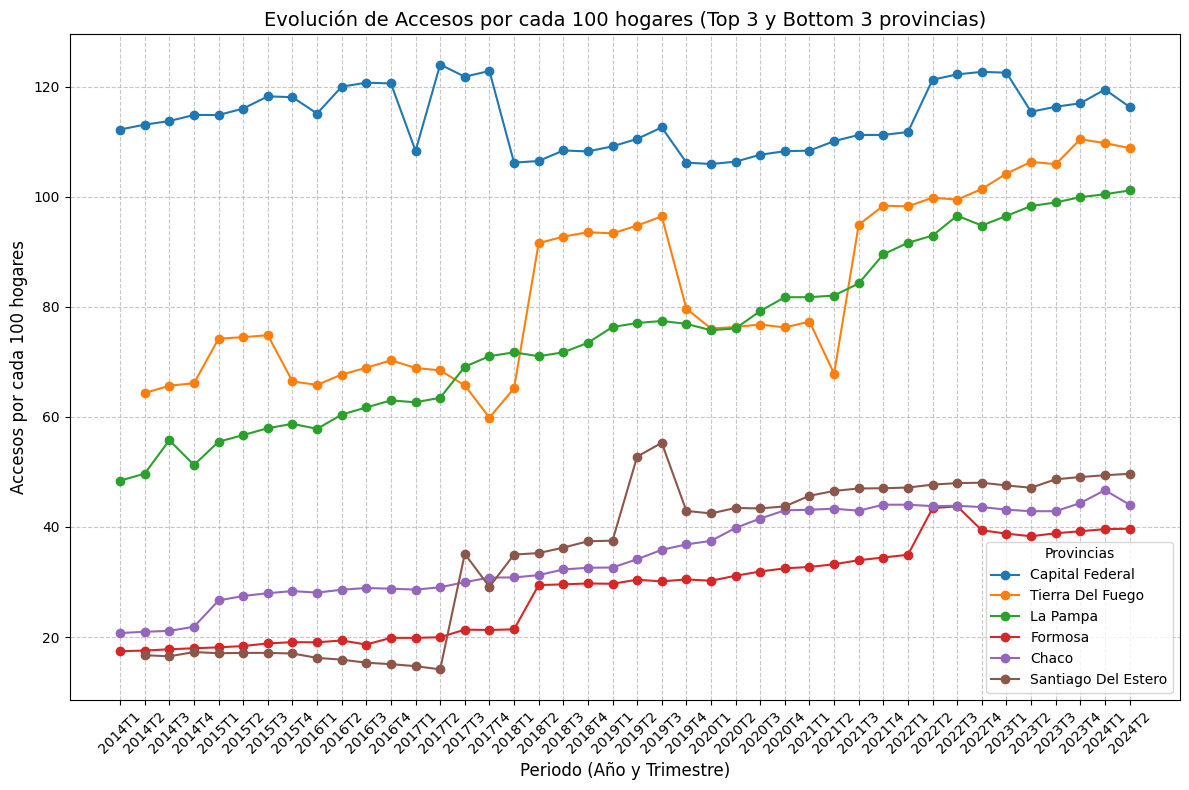

In [77]:
import matplotlib.pyplot as plt

# Calcular el promedio de "Accesos por cada 100 hogares" por provincia
promedios_provincia = penetracion_hogares.groupby('Provincia')['Accesos por cada 100 hogares'].mean()

# Obtener las tres mejores y tres peores provincias
top_3_provincias = promedios_provincia.nlargest(3).index
bottom_3_provincias = promedios_provincia.nsmallest(3).index

# Filtrar los datos para estas provincias
provincias_interes = list(top_3_provincias) + list(bottom_3_provincias)
df_interes = penetracion_hogares[penetracion_hogares['Provincia'].isin(provincias_interes)]

# Crear un gráfico para cada provincia
plt.figure(figsize=(12, 8))

for provincia in provincias_interes:
    datos_provincia = df_interes[df_interes['Provincia'] == provincia]
    datos_provincia = datos_provincia.sort_values(by=['Año', 'Trimestre'])
    plt.plot(
        datos_provincia['Año'].astype(str) + "T" + datos_provincia['Trimestre'].astype(str),
        datos_provincia['Accesos por cada 100 hogares'],
        marker='o',
        label=provincia
    )

# Configurar el gráfico
plt.title('Evolución de Accesos por cada 100 hogares (Top 3 y Bottom 3 provincias)', fontsize=14)
plt.xlabel('Periodo (Año y Trimestre)', fontsize=12)
plt.ylabel('Accesos por cada 100 hogares', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Provincias', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Tendencias Generales**
1. **Crecimiento continuo en Capital Federal y Tierra del Fuego (Top 3)**
   - **Capital Federal** lidera consistentemente con más de **120 accesos por cada 100 hogares** en los últimos años, alcanzando una cobertura sobresaliente. Esto sugiere:
     - Alta inversión en infraestructura.
     - Demanda significativa en un área densamente poblada y económicamente activa.
   - **Tierra del Fuego** muestra una mejora significativa en los últimos años, acercándose a **100 accesos por cada 100 hogares**, destacando un esfuerzo notable para mejorar la conectividad en una región más remota.

2. **Mejoras en provincias intermedias como La Pampa**
   - **La Pampa** muestra un crecimiento sostenido a lo largo del tiempo, alcanzando **80 accesos por cada 100 hogares**. Esto indica que las provincias intermedias han logrado reducir la brecha digital en relación con las regiones más avanzadas.

3. **Estancamiento o crecimiento limitado en las provincias del Bottom 3**
   - **Formosa, Chaco y Santiago del Estero** presentan un crecimiento lento y aún permanecen por debajo de **40 accesos por cada 100 hogares**, evidenciando:
     - Desafíos para expandir infraestructura en estas regiones.
     - Posibles limitaciones económicas y demográficas que dificultan la adopción de nuevas tecnologías.

**Eventos o anomalías**
- Se observan **caídas ocasionales** en varias provincias, como en Tierra del Fuego y La Pampa. Estas caídas podrían deberse a:
  - Problemas temporales en infraestructura o conectividad.
  - Cambios metodológicos en la recopilación de datos.

**Comparación Regional**
- Las provincias del Top 3 tienen una trayectoria ascendente clara, destacándose por inversiones constantes en infraestructura.
- Las provincias del Bottom 3 muestran una **brecha digital significativa** que se ha reducido parcialmente en los últimos años, pero aún persiste, indicando que se necesita mayor atención para garantizar la igualdad en el acceso a internet.

**Conclusión**
- El gráfico refleja un **avance heterogéneo** en la conectividad de internet en Argentina:
  - Las áreas urbanas y económicamente activas, como Capital Federal, han alcanzado niveles de acceso excepcionales.
  - Regiones más remotas y menos desarrolladas, como Formosa y Santiago del Estero, necesitan más inversión y políticas públicas específicas para cerrar la brecha digital.
- Este análisis resalta la importancia de continuar con la expansión de infraestructura para garantizar un acceso equitativo en todo el país.


In [78]:
penetracion_hogares.describe()

,Año,Trimestre,Accesos por cada 100 hogares
count,1000.000000,1000.000000,1000.000000
mean,2018.800000,2.464000,52.794973
std,3.021445,1.114426,24.135063
min,2014.000000,1.000000,9.513970
25%,2016.000000,1.000000,33.957657
50%,2019.000000,2.000000,50.133004
75%,2021.000000,3.000000,67.010861
max,2024.000000,4.000000,124.061394


In [79]:
# Filtrar registros donde 'Accesos por cada 100 hogares' sea mayor a 100
accesos_mayores_100 = penetracion_hogares[penetracion_hogares['Accesos por cada 100 hogares'] > 100]

# Mostrar los registros
print(accesos_mayores_100.head())
print('El total de registros mayores a 100 es',len(accesos_mayores_100))

     Año  Trimestre         Provincia  Accesos por cada 100 hogares
1   2024          2   Capital Federal                        116.37
10  2024          2          La Pampa                        101.17
18  2024          2          San Luis                        103.40
22  2024          2  Tierra Del Fuego                        108.89
25  2024          1   Capital Federal                        119.53
El total de registros mayores a 100 es 54


### *Posible Explicación*:

Es posible que se observen valores superiores a 100 en la columna "Accesos por cada 100 hogares" debido a la metodología de cálculo y a la dinámica del mercado de servicios de internet. A continuación, se detallan algunas razones que pueden explicar esta situación:

1. **Multiplicidad de Accesos por Hogar:** En algunos casos, un mismo hogar puede contar con múltiples conexiones a internet. Por ejemplo, una familia podría tener una conexión de banda ancha fija y, adicionalmente, una conexión inalámbrica o móvil. Esta duplicidad incrementa el número total de accesos, superando la cantidad de hogares y, por ende, generando una tasa de penetración que excede el 100%. ***Lo mas probable:*** *hogares con wifi y con varios teléfonos móviles, debido a la cantidad de habitantes de la casa.*

2. **Cálculo Basado en Datos de Hogares Estáticos:** Si el denominador utilizado para calcular la tasa de penetración (es decir, el número de hogares) se basa en datos censales que no se actualizan con la misma frecuencia que los datos de accesos, es posible que el crecimiento en el número de conexiones no se refleje proporcionalmente en el número de hogares. Esto puede llevar a que la tasa de penetración aumente por encima del 100%, especialmente en áreas con rápido crecimiento en la adopción de servicios de internet. [Link](https://indicadores.enacom.gob.ar/files/informes/2019/T3/2019T3-03%20-%20Acceso%20a%20Internet%20Fija.pdf)

Estas situaciones reflejan la complejidad y la evolución dinámica del mercado de servicios de internet, donde la adopción de múltiples conexiones por hogar y la actualización asincrónica de los datos demográficos pueden influir en las métricas de penetración.

In [80]:
print(penetracion_hogares['Año'].value_counts())
print(penetracion_hogares['Trimestre'].value_counts())
print(penetracion_hogares['Provincia'].value_counts())

Año
2023    96
2022    96
2021    96
2017    96
2020    96
2019    96
2018    96
2015    96
2016    96
2014    88
2024    48
Name: count, dtype: int64
Trimestre
2    264
1    256
4    240
3    240
Name: count, dtype: int64
Provincia
Buenos Aires           42
Capital Federal        42
Catamarca              42
Chaco                  42
Chubut                 42
Córdoba                42
Corrientes             42
Entre Ríos             42
Formosa                42
Jujuy                  42
La Pampa               42
La Rioja               42
Mendoza                42
Misiones               42
Neuquén                42
Río Negro              42
Salta                  41
San Juan               41
San Luis               41
Santa Cruz             41
Santa Fe               41
Santiago Del Estero    41
Tierra Del Fuego       41
Tucumán                41
Name: count, dtype: int64


### Normalizar la columna `Provincia`

In [81]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
penetracion_hogares['Provincia'] = penetracion_hogares['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
penetracion_hogares['Provincia'] = penetracion_hogares['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(penetracion_hogares['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


In [82]:
# Ordenar por Año y Trimestre para garantizar el orden cronológico
acc_tec_sorted = acc_tec.sort_values(by=['Año', 'Trimestre'])

# Obtener el primer registro (inicio del rango de tiempo)
primer_trimestre = acc_tec_sorted.iloc[0]

# Obtener el último registro (fin del rango de tiempo)
ultimo_trimestre = acc_tec_sorted.iloc[-1]

# Mostrar los resultados
print("Primer trimestre registrado:")
print(primer_trimestre[['Año', 'Trimestre']])
print("\nÚltimo trimestre registrado:")
print(ultimo_trimestre[['Año', 'Trimestre']])

Primer trimestre registrado:
Año          2014
Trimestre       1
Name: 983, dtype: object

Último trimestre registrado:
Año          2024
Trimestre       2
Name: 23, dtype: object


# Procesamiento del df `acc_rangos`

In [83]:
acc_rangos = pd.read_excel(path, sheet_name='Accesos por rangos')

In [84]:
acc_rangos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Año                  1000 non-null   int64  
 1   Trimestre            1000 non-null   int64  
 2   Provincia            1000 non-null   object 
 3   HASTA 512 kbps       1000 non-null   float64
 4   + 512 Kbps - 1 Mbps  1000 non-null   float64
 5   + 1 Mbps - 6 Mbps    1000 non-null   float64
 6   + 6 Mbps - 10 Mbps   1000 non-null   float64
 7   + 10 Mbps - 20 Mbps  1000 non-null   float64
 8   + 20 Mbps - 30 Mbps  1000 non-null   float64
 9   + 30 Mbps            1000 non-null   float64
 10  OTROS                994 non-null    float64
 11  Total                1000 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 93.9+ KB


In [85]:
acc_rangos.describe()

,Año,Trimestre,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,994.000000,1.000000e+03
mean,2018.824000,2.464000,1953.317000,8864.257000,1.327725e+05,38408.510000,37138.329000,20091.330000,1.222098e+05,6510.467807,3.679094e+05
std,3.058493,1.114426,12676.575806,20312.520997,3.222569e+05,64156.365883,88290.744464,69299.281156,4.657500e+05,15344.465875,7.899348e+05
min,2014.000000,1.000000,6.000000,0.000000,1.124000e+03,0.000000,0.000000,0.000000,0.000000e+00,-1945.000000,1.240600e+04
25%,2016.000000,1.000000,43.250000,389.750000,2.381250e+04,3876.750000,2706.750000,43.750000,1.500000e+01,0.000000,6.234225e+04
50%,2019.000000,2.000000,107.000000,2061.000000,4.213250e+04,13932.000000,10503.000000,1658.000000,4.253500e+03,346.500000,1.136205e+05
75%,2021.000000,3.000000,466.250000,6851.500000,8.371025e+04,42593.500000,26463.750000,10109.250000,4.339925e+04,6830.750000,1.969198e+05
max,2024.000000,4.000000,238920.000000,171244.480000,2.299705e+06,403575.000000,886678.000000,949093.000000,4.068292e+06,125547.000000,5.044557e+06


In [86]:
acc_rangos

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
0,2024,2,Buenos Aires,25287.0,23034.0,222627.0,221660.0,244528.0,106302.0,4020395.0,125547.0,4989380.0
1,2024,2,Capital Federal,518.0,4122.0,24539.0,40296.0,33158.0,5633.0,1355333.0,0.0,1463599.0
2,2024,2,Catamarca,72.0,164.0,2660.0,3093.0,3799.0,1279.0,63954.0,53.0,75074.0
3,2024,2,Chaco,236.0,349.0,14594.0,8336.0,6208.0,6454.0,107707.0,3208.0,147092.0
4,2024,2,Chubut,125.0,1139.0,43699.0,31971.0,22696.0,19827.0,38212.0,16554.0,174223.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2014,1,La Rioja,10.0,5111.0,9390.0,1165.0,35.0,0.0,0.0,0.0,15711.0
996,2014,1,Mendoza,35.0,6.0,166655.0,19.0,10.0,6.0,9.0,0.0,166740.0
997,2014,1,Misiones,545.0,14460.0,52852.0,5139.0,958.0,0.0,0.0,0.0,73954.0
998,2014,1,Neuquén,4133.0,987.0,77148.0,84.0,1582.0,2.0,22.0,0.0,83958.0


In [87]:
# Filtrar registros donde 'OTROS' sea nulo
acc_rangos_nulos = acc_rangos[acc_rangos['OTROS'].isnull()]

# Mostrar los registros
acc_rangos_nulos

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
481,2019,2,Capital Federal,74.0,1027.0,281370.0,124087.0,239691.0,296155.0,475991.0,NaN,1418395.0
491,2019,2,La Rioja,9.0,11.0,39819.0,4297.0,4857.0,13.0,1298.0,NaN,50304.0
492,2019,2,Mendoza,20.0,2522.0,205165.0,2971.0,10092.0,1256.0,234.0,NaN,222260.0
499,2019,2,Santa Cruz,25.0,84.0,24861.0,3806.0,1202.0,28.0,4.0,NaN,30010.0
502,2019,2,Tierra Del Fuego,6.0,123.0,41824.0,4241.0,1573.0,96.0,32.0,NaN,47895.0
503,2019,2,Tucumán,16.0,157.0,78891.0,44296.0,24291.0,628.0,18394.0,NaN,166673.0


Imputo los nulos con la diferencia del total con todos los otros rangos.

In [88]:
# Imputar valores nulos en 'OTROS' con la diferencia entre el 'Total' y la suma de los rangos
acc_rangos['OTROS'] = acc_rangos.apply(
    lambda row: row['Total'] - (
        row['HASTA 512 kbps'] +
        row['+ 512 Kbps - 1 Mbps'] +
        row['+ 1 Mbps - 6 Mbps'] +
        row['+ 6 Mbps - 10 Mbps'] +
        row['+ 10 Mbps - 20 Mbps'] +
        row['+ 20 Mbps - 30 Mbps'] +
        row['+ 30 Mbps']
    ) if pd.isnull(row['OTROS']) else row['OTROS'], axis=1
)

In [89]:
# Filtrar las filas específicas
filas_especificas = acc_rangos.loc[[481, 491, 492, 499, 502, 503]]

# Mostrar las filas filtradas
filas_especificas

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
481,2019,2,Capital Federal,74.0,1027.0,281370.0,124087.0,239691.0,296155.0,475991.0,0.0,1418395.0
491,2019,2,La Rioja,9.0,11.0,39819.0,4297.0,4857.0,13.0,1298.0,0.0,50304.0
492,2019,2,Mendoza,20.0,2522.0,205165.0,2971.0,10092.0,1256.0,234.0,0.0,222260.0
499,2019,2,Santa Cruz,25.0,84.0,24861.0,3806.0,1202.0,28.0,4.0,0.0,30010.0
502,2019,2,Tierra Del Fuego,6.0,123.0,41824.0,4241.0,1573.0,96.0,32.0,0.0,47895.0
503,2019,2,Tucumán,16.0,157.0,78891.0,44296.0,24291.0,628.0,18394.0,0.0,166673.0


In [90]:
#Filtrar los valores negativos de 'OTROS'
negativos = acc_rangos[acc_rangos['OTROS']< 0]
negativos

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
323,2021,1,La Rioja,18.0,1.0,36749.0,5968.0,4604.0,215.0,5074.0,-1.0,52628.0
331,2021,1,Santa Cruz,50.0,0.0,30655.0,8334.0,6987.0,1337.0,647.0,-1945.0,46065.0


In [91]:
# Cambiar esos valores a cero, ya que no puede haber valores negativos de accesos
acc_rangos.loc[acc_rangos['OTROS'] < 0, 'OTROS'] = 0

# Verificar que ya no haya valores negativos
print(acc_rangos['OTROS'].min())  # Esto debería mostrar 0 o mayor

0.0


### Corroboro que los valores de `Provincia` esten correctos

In [92]:
print(acc_rangos['Provincia'].value_counts())

Provincia
Buenos Aires           42
Capital Federal        42
Catamarca              42
Chaco                  42
Chubut                 42
Córdoba                42
Corrientes             42
Entre Ríos             42
Formosa                42
Jujuy                  42
La Pampa               42
La Rioja               42
Mendoza                42
Misiones               42
Neuquén                42
Río Negro              42
Salta                  41
San Juan               41
San Luis               41
Santa Cruz             41
Santa Fe               41
Santiago Del Estero    41
Tierra Del Fuego       41
Tucumán                41
Name: count, dtype: int64


### Normalizar la columna `Provincia`

In [93]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
acc_rangos['Provincia'] = acc_rangos['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
acc_rangos['Provincia'] = acc_rangos['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(acc_rangos['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


In [94]:
fechas_rangos = acc_rangos[['Año', 'Trimestre']]
print(len(fechas_rangos))
print(fechas_rangos.value_counts())


1000
Año   Trimestre
2014  2            24
      3            24
2015  3            24
2014  4            24
2015  1            24
      2            24
2016  1            24
2015  4            24
2016  2            24
      3            24
2020  3            24
2016  4            24
2017  1            24
      2            24
      3            24
      4            24
2018  1            24
      2            24
      3            24
      4            24
2019  1            24
      2            24
      3            24
      4            24
2020  1            24
      2            24
2022  3            24
2020  4            24
2021  1            24
      2            24
      3            24
      4            24
2022  1            24
      2            24
2023  3            24
2022  4            24
2023  1            24
      2            24
2024  2            24
      1            24
      4            24
2014  1            16
Name: count, dtype: int64


Me faltan 2 trimestres. Para los años 2023 y 2024 tengo lo siguiente:
```
2023  3            24
2023  1            24
2023  2            24

2024  2            24
2024  1            24
2024  4            24
```
Lo corroboro con filtros


In [95]:
# Crear un DataFrame con todos los trimestres esperados
años = [2023, 2024]
trimestres = [1, 2, 3, 4]
todos_los_trimestres = pd.DataFrame([(año, trimestre) for año in años for trimestre in trimestres], columns=['Año', 'Trimestre'])

# DataFrame actual con las fechas disponibles
fechas_rangos = acc_rangos[['Año', 'Trimestre']].drop_duplicates()

# Encontrar las fechas faltantes
fechas_faltantes = pd.merge(todos_los_trimestres, fechas_rangos, on=['Año', 'Trimestre'], how='left', indicator=True)
fechas_faltantes = fechas_faltantes[fechas_faltantes['_merge'] == 'left_only'].drop(columns=['_merge'])

# Mostrar los trimestres faltantes
print("Fechas Faltantes:")
print(fechas_faltantes)


Fechas Faltantes:
    Año  Trimestre
3  2023          4
6  2024          3


In [96]:
# Crear un DataFrame con las fechas faltantes
fechas_faltantes = pd.DataFrame({
    'Año': [2023, 2024],
    'Trimestre': [4, 3]
})

# Verificar si las fechas faltantes están en nuevo_df_rangos
fechas_encontradas = fechas_faltantes.merge(
    nuevo_df_rangos[['Año', 'Trimestre']].drop_duplicates(),
    on=['Año', 'Trimestre'],
    how='left',
    indicator=True
)

# Convertir _merge a string antes de usar replace
fechas_encontradas['_merge'] = fechas_encontradas['_merge'].astype(str).replace({
    'both': 'Encontrada',
    'left_only': 'Faltante'
})

# Mostrar el resultado
print(fechas_encontradas)

    Año  Trimestre      _merge
0  2023          4  Encontrada
1  2024          3    Faltante


In [97]:
# Filtrar los registros faltantes de nuevo_df_rangos con base en fechas_faltantes
datos_faltantes = nuevo_df_rangos.merge(
    fechas_faltantes,
    on=['Año', 'Trimestre'],
    how='right',  # Queremos mantener las fechas faltantes aunque no estén en nuevo_df_rangos
    indicator=True
)

# Filtrar solo los registros que no están en nuevo_df_rangos
datos_faltantes = datos_faltantes[datos_faltantes['_merge'] == 'right_only']

# Verificar el resultado
print(datos_faltantes)
print(datos_faltantes.info())

     Año  Trimestre Provincia  HASTA 512 kbps  + 512 Kbps - 1 Mbps  \
24  2024          3       NaN             NaN                  NaN   

    + 1 Mbps - 6 Mbps  + 6 Mbps - 10 Mbps  + 10 Mbps - 20 Mbps  \
24                NaN                 NaN                  NaN   

    + 20 Mbps - 30 Mbps  + 30 Mbps      _merge  
24                  NaN        NaN  right_only  
<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 24 to 24
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Año                  1 non-null      int64   
 1   Trimestre            1 non-null      int64   
 2   Provincia            0 non-null      object  
 3   HASTA 512 kbps       0 non-null      float64 
 4   + 512 Kbps - 1 Mbps  0 non-null      float64 
 5   + 1 Mbps - 6 Mbps    0 non-null      float64 
 6   + 6 Mbps - 10 Mbps   0 non-null      float64 
 7   + 10 Mbps - 20 Mbps  0 non-null      float64 
 8   + 20 Mbps - 30 

In [98]:
acc_rangos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Año                  1000 non-null   int64  
 1   Trimestre            1000 non-null   int64  
 2   Provincia            1000 non-null   object 
 3   HASTA 512 kbps       1000 non-null   float64
 4   + 512 Kbps - 1 Mbps  1000 non-null   float64
 5   + 1 Mbps - 6 Mbps    1000 non-null   float64
 6   + 6 Mbps - 10 Mbps   1000 non-null   float64
 7   + 10 Mbps - 20 Mbps  1000 non-null   float64
 8   + 20 Mbps - 30 Mbps  1000 non-null   float64
 9   + 30 Mbps            1000 non-null   float64
 10  OTROS                1000 non-null   float64
 11  Total                1000 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 93.9+ KB


Imputación de los datos faltantes del 4to trimestre del 2023. 

In [99]:
# Filtrar los datos de nuevo_df_rangos correspondientes al T4 2023
datos_t4_2023 = nuevo_df_rangos[(nuevo_df_rangos['Año'] == 2023) & (nuevo_df_rangos['Trimestre'] == 4)].copy()

# Asegurarnos de agregar las columnas faltantes en acc_rangos
# Si no existe la columna 'OTROS', se añade con ceros
datos_t4_2023.loc[:, 'OTROS'] = 0

# Si no existe la columna 'Total', se calcula como la suma de los rangos
datos_t4_2023.loc[:, 'Total'] = datos_t4_2023[
    ['HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps',
     '+ 6 Mbps - 10 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps', '+ 30 Mbps', 'OTROS']
].sum(axis=1)

# Concatenar los datos de T4 2023 a acc_rangos
acc_rangos = pd.concat([acc_rangos, datos_t4_2023], ignore_index=True)

# Verificar que los datos se hayan añadido correctamente
print(acc_rangos[(acc_rangos['Año'] == 2023) & (acc_rangos['Trimestre'] == 4)])
print(acc_rangos.info())



       Año  Trimestre            Provincia  HASTA 512 kbps  \
1000  2023          4         Buenos Aires         93370.0   
1001  2023          4      Capital Federal            31.0   
1002  2023          4            Catamarca            77.0   
1003  2023          4                Chaco          4040.0   
1004  2023          4               Chubut         16597.0   
1005  2023          4              Cordoba         17063.0   
1006  2023          4           Corrientes          6484.0   
1007  2023          4           Entre Rios         14383.0   
1008  2023          4              Formosa           351.0   
1009  2023          4                Jujuy          1980.0   
1010  2023          4             La Pampa          1613.0   
1011  2023          4             La Rioja             0.0   
1012  2023          4              Mendoza          5501.0   
1013  2023          4             Misiones          8925.0   
1014  2023          4              Neuquen         20177.0   
1015  20

# Procesamiento del df `dial_baf`

In [100]:
dial_baf = pd.read_excel(path, sheet_name='Dial-BAf')

In [101]:
dial_baf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               1992 non-null   int64  
 1   Trimestre         1992 non-null   int64  
 2   Provincia         1992 non-null   object 
 3   Banda ancha fija  1992 non-null   int64  
 4   Dial up           1988 non-null   float64
 5   Total             1992 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 93.5+ KB


In [102]:
dial_baf.head()

,Año,Trimestre,Provincia,Banda ancha fija,Dial up,Total
0,2024,2,Buenos Aires,4983480,5900.0,4989380
1,2024,2,Capital Federal,1461549,2050.0,1463599
2,2024,2,Catamarca,75073,1.0,75074
3,2024,2,Chaco,147087,5.0,147092
4,2024,2,Chubut,173366,857.0,174223


Uso el mismo criterio anteriormente empleado para imputar los nulos. La diferencia entre `Total` y el valor de `Banda Ancha Fija`

In [103]:
# Filtrar registros donde 'Dial up' sea nulo
dial_baf_nulos = dial_baf[dial_baf['Dial up'].isnull()]

# Mostrar los registros
dial_baf_nulos

,Año,Trimestre,Provincia,Banda ancha fija,Dial up,Total
584,2018,2,Formosa,44554,NaN,44554
589,2018,2,Misiones,106147,NaN,106147
1568,2018,2,Formosa,44554,NaN,44554
1573,2018,2,Misiones,106147,NaN,106147


In [104]:
# Imputar valores nulos en 'Dial up' con la diferencia entre el 'Total' y el valor de 'Banda Ancha Fija'
dial_baf['Dial up'] = dial_baf.apply(
    lambda row: row['Total'] - row['Banda ancha fija'] if pd.isnull(row['Dial up']) else row['Dial up'], axis=1
)

In [105]:
# Filtrar las filas específicas
filas_especificas = dial_baf.loc[[584,589,1568,1573]]

# Mostrar las filas filtradas
filas_especificas

,Año,Trimestre,Provincia,Banda ancha fija,Dial up,Total
584,2018,2,Formosa,44554,0.0,44554
589,2018,2,Misiones,106147,0.0,106147
1568,2018,2,Formosa,44554,0.0,44554
1573,2018,2,Misiones,106147,0.0,106147


In [106]:
filas_especificas = dial_baf.loc[[584,589,1568,1573]]

In [107]:
print(dial_baf['Año'].value_counts())
print(dial_baf['Trimestre'].value_counts())
print(dial_baf['Provincia'].value_counts())

Año
2023    192
2022    192
2021    192
2017    192
2020    192
2019    192
2018    192
2015    192
2016    192
2014    192
2024     72
Name: count, dtype: int64
Trimestre
1    528
2    504
4    480
3    480
Name: count, dtype: int64
Provincia
Buenos Aires           83
Capital Federal        83
Catamarca              83
Chaco                  83
Chubut                 83
Córdoba                83
Corrientes             83
Entre Ríos             83
Formosa                83
Jujuy                  83
La Pampa               83
La Rioja               83
Mendoza                83
Misiones               83
Neuquén                83
Río Negro              83
Salta                  83
San Juan               83
San Luis               83
Santa Cruz             83
Santa Fe               83
Santiago Del Estero    83
Tierra Del Fuego       83
Tucumán                83
Name: count, dtype: int64


### Normalizar la columna `Provincia`

In [108]:
# Convertir los datos de 'Provincia' a minúsculas, quitar acentos y luego a formato título
dial_baf['Provincia'] = dial_baf['Provincia'] \
    .str.lower() \
    .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) \
    .str.title()

# Unificar "Caba" y "Capital Federal" en "Capital Federal"
dial_baf['Provincia'] = dial_baf['Provincia'].replace(
    ['Caba', 'Capital Federal'], 'Capital Federal'
)

# Confirmar el cambio
print(dial_baf['Provincia'].unique())

['Buenos Aires' 'Capital Federal' 'Catamarca' 'Chaco' 'Chubut' 'Cordoba'
 'Corrientes' 'Entre Rios' 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja'
 'Mendoza' 'Misiones' 'Neuquen' 'Rio Negro' 'Salta' 'San Juan' 'San Luis'
 'Santa Cruz' 'Santa Fe' 'Santiago Del Estero' 'Tierra Del Fuego'
 'Tucuman']


In [109]:
# Ordenar por Año y Trimestre para garantizar el orden cronológico
dial_baf_sorted = dial_baf.sort_values(by=['Año', 'Trimestre'])

# Obtener el primer registro (inicio del rango de tiempo)
primer_trimestre = dial_baf_sorted.iloc[0]

# Obtener el último registro (fin del rango de tiempo)
ultimo_trimestre = dial_baf_sorted.iloc[-1]

# Mostrar los resultados
print("Primer trimestre registrado:")
print(primer_trimestre[['Año', 'Trimestre']])
print("\nÚltimo trimestre registrado:")
print(ultimo_trimestre[['Año', 'Trimestre']])

Primer trimestre registrado:
Año          2014
Trimestre       1
Name: 984, dtype: object

Último trimestre registrado:
Año          2024
Trimestre       2
Name: 23, dtype: object


In [110]:
# Verificar duplicados para las combinaciones de 'Año', 'Trimestre' y 'Provincia'
duplicados = dial_baf[dial_baf.duplicated(subset=['Año', 'Trimestre', 'Provincia'], keep=False)]

# Mostrar los duplicados
print("Registros duplicados:")
print(duplicados)

# Contar el número de duplicados
print("\nNúmero total de duplicados:", len(duplicados))


Registros duplicados:
       Año  Trimestre            Provincia  Banda ancha fija  Dial up    Total
24    2024          1         Buenos Aires           5038657   5900.0  5044557
25    2024          1      Capital Federal           1502661   2050.0  1504711
26    2024          1            Catamarca             74932      1.0    74933
27    2024          1                Chaco            155538      5.0   155543
28    2024          1               Chubut            169819    857.0   170676
...    ...        ...                  ...               ...      ...      ...
1987  2014          1           Santa Cruz             26304    460.0    26764
1988  2014          1             Santa Fe            506000    612.0   506612
1989  2014          1  Santiago Del Estero             37124      9.0    37133
1990  2014          1     Tierra Del Fuego             27272    766.0    28038
1991  2014          1              Tucuman            129944     88.0   130032

[1968 rows x 6 columns]

Núme

In [111]:
# Verificar la cantidad de duplicados antes de eliminarlos
duplicados_totales = dial_baf.duplicated(keep=False).sum()
print(f"Total de duplicados absolutos encontrados: {duplicados_totales}")

# Eliminar duplicados absolutos
dial_baf = dial_baf.drop_duplicates(keep='first')

# Verificar el DataFrame después de eliminar duplicados
print(f"Total de registros después de eliminar duplicados: {len(dial_baf)}")


Total de duplicados absolutos encontrados: 1968
Total de registros después de eliminar duplicados: 1008


## **Combinación de dfs**

Dada la información que contienen, voy a combinar los dfs `vel_porc_prov`, `acc_tec` y `dial_baf`, basándome en el año, trimestre y provincia

In [112]:
# Combinar vel_porc_prov y acc_tec usando un merge
merge1 = pd.merge(vel_por_prov, acc_tec, on=['Año', 'Trimestre', 'Provincia'], how='outer')

# Combinar el resultado con dial_baf usando un segundo merge
internet_accesos = pd.merge(merge1, dial_baf, on=['Año', 'Trimestre', 'Provincia'], how='outer')

# Verificar el resultado
print(f"Total de registros en el DataFrame combinado: {len(internet_accesos)}")


Total de registros en el DataFrame combinado: 1008


In [113]:
internet_accesos.head()

,Año,Trimestre,Provincia,Mbps (Media de bajada),ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total_x,Banda ancha fija,Dial up,Total_y
0,2014,1,Buenos Aires,3.733133,1567685.0,1000879.0,120960.0,16528.0,33824.0,2739876.0,2725732,14144.0,2739876
1,2014,1,Capital Federal,4.024082,445569.0,820161.0,17767.0,1866.0,14555.0,1299918.0,1289204,10714.0,1299918
2,2014,1,Catamarca,2.802734,24126.0,46.0,17.0,0.0,43.0,24232.0,24209,23.0,24232
3,2014,1,Chaco,3.255837,52971.0,9497.0,30.0,0.0,58.0,62556.0,62520,36.0,62556
4,2014,1,Chubut,3.175917,51066.0,539.0,866.0,10776.0,6974.0,70221.0,68205,2016.0,70221


In [114]:
internet_accesos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año                     1008 non-null   int64  
 1   Trimestre               1008 non-null   int64  
 2   Provincia               1008 non-null   object 
 3   Mbps (Media de bajada)  1008 non-null   float64
 4   ADSL                    1007 non-null   float64
 5   Cablemodem              1007 non-null   float64
 6   Fibra óptica            1007 non-null   float64
 7   Wireless                1007 non-null   float64
 8   Otros                   1007 non-null   float64
 9   Total_x                 1007 non-null   float64
 10  Banda ancha fija        1008 non-null   int64  
 11  Dial up                 1008 non-null   float64
 12  Total_y                 1008 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 102.5+ KB


In [115]:
# Filtrar los registros que tienen valores nulos en cualquier columna
registros_con_nulos = internet_accesos[internet_accesos.isnull().any(axis=1)]

# Mostrar los registros con valores nulos
registros_con_nulos

,Año,Trimestre,Provincia,Mbps (Media de bajada),ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total_x,Banda ancha fija,Dial up,Total_y
960,2024,1,Buenos Aires,159.13,NaN,NaN,NaN,NaN,NaN,NaN,5038657,5900.0,5044557


In [116]:
# Eliminar las filas que tienen valores nulos
internet_accesos = internet_accesos.dropna()

# Confirmar que se eliminó el registro
internet_accesos.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, 0 to 1007
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año                     1007 non-null   int64  
 1   Trimestre               1007 non-null   int64  
 2   Provincia               1007 non-null   object 
 3   Mbps (Media de bajada)  1007 non-null   float64
 4   ADSL                    1007 non-null   float64
 5   Cablemodem              1007 non-null   float64
 6   Fibra óptica            1007 non-null   float64
 7   Wireless                1007 non-null   float64
 8   Otros                   1007 non-null   float64
 9   Total_x                 1007 non-null   float64
 10  Banda ancha fija        1007 non-null   int64  
 11  Dial up                 1007 non-null   float64
 12  Total_y                 1007 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 110.1+ KB


In [117]:
internet_accesos.to_csv(r'C:\Users\paula\OneDrive\Curso\Henry\Proyecto Individual\2da parte\Telecomunucaciones_AR\Datasets procesados\internet_accesos.csv', index=False)

Dada la información que contienen, voy a combinar los dfs `penetracion_hab`, `penetracion_hogares` y `acc_rangos`, basándome en el año, trimestre y provincia

In [118]:
# Combinar vel_porc_prov y acc_tec usando un merge
merge1 = pd.merge(penetracion_pob, penetracion_hogares, on=['Año', 'Trimestre', 'Provincia'], how='outer')

# Combinar el resultado con dial_baf usando un segundo merge
internet_penetracion = pd.merge(merge1, acc_rangos, on=['Año', 'Trimestre', 'Provincia'], how='outer')

# Verificar el resultado
print(f"Total de registros en el DataFrame combinado: {len(internet_penetracion)}")


Total de registros en el DataFrame combinado: 1024


In [119]:
# Filtrar registros que tienen al menos un valor nulo
registros_con_nulos = internet_penetracion[internet_penetracion.isnull().any(axis=1)]

# Contar el número total de registros con nulos
print(f"\nTotal de registros con valores nulos: {len(registros_con_nulos)}")



Total de registros con valores nulos: 24


In [120]:
registros_con_nulos

,Año,Trimestre,Provincia,Accesos por cada 100 hab,Accesos por cada 100 hogares,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
1000,2024,4,Buenos Aires,NaN,NaN,26909.0,23962.0,228393.0,239339.0,246144.0,110876.0,4042646.0,93351.0,5011620.0
1001,2024,4,Capital Federal,NaN,NaN,516.0,4544.0,26409.0,48083.0,33925.0,5829.0,1355061.0,0.0,1474367.0
1002,2024,4,Catamarca,NaN,NaN,71.0,209.0,3065.0,3734.0,4423.0,1827.0,61181.0,77.0,74587.0
1003,2024,4,Chaco,NaN,NaN,236.0,477.0,14811.0,10361.0,6247.0,5729.0,105485.0,4040.0,147386.0
1004,2024,4,Chubut,NaN,NaN,111.0,1088.0,44276.0,31402.0,22843.0,20196.0,33665.0,16589.0,170170.0
1005,2024,4,Cordoba,NaN,NaN,99.0,8404.0,117068.0,91169.0,51126.0,26948.0,767427.0,17061.0,1079302.0
1006,2024,4,Corrientes,NaN,NaN,67.0,2889.0,19949.0,17984.0,8108.0,5087.0,98904.0,6484.0,159472.0
1007,2024,4,Entre Rios,NaN,NaN,107.0,4408.0,37150.0,54377.0,16673.0,7236.0,164304.0,14382.0,298637.0
1008,2024,4,Formosa,NaN,NaN,85.0,179.0,21856.0,11563.0,4545.0,272.0,23152.0,350.0,62002.0
1009,2024,4,Jujuy,NaN,NaN,58.0,1343.0,15359.0,11724.0,28741.0,272.0,58543.0,1980.0,118020.0


### Para imputar los valores faltantes del df, con los valores del df `vel_sin_rangos`

In [121]:
# Definición de los rangos y etiquetas para clasificar las velocidades
rangos = [0, 0.512, 1, 6, 10, 20, 30, float('inf')]
etiquetas = [
    'HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps',
    '+ 6 Mbps - 10 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps',
    '+ 30 Mbps'
]

# Paso 1: Filtrar los datos de vel_sin_rangos para el trimestre 4 del 2023
datos_rangos = vel_sin_rangos[
    (vel_sin_rangos['Año'] == 2023) & 
    (vel_sin_rangos['Trimestre'] == 4)
].copy()

# Paso 2: Clasificar las velocidades en rangos
datos_rangos['Rango'] = pd.cut(datos_rangos['Velocidad'], bins=rangos, labels=etiquetas, right=False)

# Paso 3: Agrupar por Año, Trimestre, Provincia, y Rango para sumar los accesos
df_rangos = datos_rangos.groupby(['Año', 'Trimestre', 'Provincia', 'Rango'], observed=False)['Accesos'].sum().reset_index()

# Paso 4: Reorganizar el DataFrame para que los rangos sean columnas
df_rangos = df_rangos.pivot(index=['Año', 'Trimestre', 'Provincia'], columns='Rango', values='Accesos').reset_index()

# Paso 5: Llenar los valores NaN en los rangos con 0
df_rangos = df_rangos.fillna(0)

# Paso 6: Asegurar que todas las columnas de rangos estén presentes
columnas_rangos = [
    'HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps',
    '+ 6 Mbps - 10 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps',
    '+ 30 Mbps', 'OTROS'
]
for col in columnas_rangos:
    if col not in df_rangos.columns:
        df_rangos[col] = 0

# Crear una columna Total si no existe
df_rangos['Total'] = df_rangos[columnas_rangos].sum(axis=1)

# Paso 7: Filtrar los datos existentes en internet_penetracion para el trimestre 4 del 2023
datos_existentes = internet_penetracion[
    (internet_penetracion['Año'] == 2023) & 
    (internet_penetracion['Trimestre'] == 4)
]

# Paso 8: Combinar los datos existentes y los clasificados en rangos
datos_combinados_trimestre_4_2023 = pd.merge(
    datos_existentes, 
    df_rangos, 
    on=['Año', 'Trimestre', 'Provincia'], 
    how='outer'
)

# Paso 9: Identificar las columnas con sufijos _x y _y
columnas_x = [col for col in datos_combinados_trimestre_4_2023.columns if col.endswith('_x')]
columnas_y = [col for col in datos_combinados_trimestre_4_2023.columns if col.endswith('_y')]

# Paso 10: Renombrar columnas _y eliminando el sufijo
nuevos_nombres = {col: col.rstrip('_y') for col in columnas_y}
datos_combinados_trimestre_4_2023.rename(columns=nuevos_nombres, inplace=True)

# Paso 11: Eliminar columnas _x ya que sus valores parecen no ser relevantes
datos_combinados_trimestre_4_2023.drop(columns=columnas_x, inplace=True)

# Identificar columnas que NO son rangos y que tampoco deben ser rellenadas
otros_columnas = [
    col for col in datos_combinados_trimestre_4_2023.columns 
    if col not in columnas_rangos and col not in ['Accesos por cada 100 hab', 'Accesos por cada 100 hogares']
]

# Rellenar únicamente las columnas que no son de rangos ni importantes para análisis posterior
datos_combinados_trimestre_4_2023[otros_columnas] = datos_combinados_trimestre_4_2023[otros_columnas].fillna(0)

# Paso 12: Combinar el nuevo trimestre 4 con el resto de internet_penetracion
internet_penetracion = pd.concat(
    [internet_penetracion[internet_penetracion['Trimestre'] != 4], datos_combinados_trimestre_4_2023],
    ignore_index=True
)

In [122]:
# Paso 13: Verificar los resultados
internet_penetracion[internet_penetracion['Trimestre'] == 4].tail()


,Año,Trimestre,Provincia,Accesos por cada 100 hab,Accesos por cada 100 hogares,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
779,2023,4,Santa Cruz,21.94,73.75,33438.0,46.0,4988.0,5637.0,15163.0,6302.0,21457.0,0.0,87031.0
780,2023,4,Santa Fe,25.08,79.75,16458.0,436.0,43186.0,61687.0,170503.0,46409.0,570822.0,0.0,909501.0
781,2023,4,Santiago Del Estero,12.18,49.08,932.0,178.0,8470.0,6187.0,68623.0,9422.0,29418.0,0.0,123230.0
782,2023,4,Tierra Del Fuego,32.75,110.49,7879.0,22.0,6465.0,12686.0,23904.0,6072.0,4571.0,0.0,61599.0
783,2023,4,Tucuman,15.12,61.04,562.0,39.0,9364.0,10866.0,37678.0,9923.0,197903.0,0.0,266335.0


In [123]:
internet_penetracion.describe()

,Año,Trimestre,Accesos por cada 100 hab,Accesos por cada 100 hogares,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
count,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,7.840000e+02,784.000000,784.00000,784.000000,7.840000e+02,784.000000,7.840000e+02
mean,2019.020408,2.040816,15.877570,53.290688,2315.637755,8926.723214,1.308371e+05,37663.264031,37094.01148,19436.151786,1.286153e+05,6244.317602,3.711301e+05
std,3.095680,0.868561,9.274175,24.282067,13765.393446,20713.380462,3.220578e+05,62938.856953,87860.55671,64388.259043,4.812429e+05,15221.511565,7.974414e+05
min,2014.000000,1.000000,2.723000,9.513970,0.000000,0.000000,8.790000e+02,0.000000,0.00000,0.000000,0.000000e+00,0.000000,1.240600e+04
25%,2016.000000,1.000000,9.066030,34.888623,44.000000,349.000000,2.312325e+04,3829.250000,2849.25000,46.250000,1.975000e+01,0.000000,6.289200e+04
50%,2019.000000,2.000000,13.786117,50.637846,107.000000,2027.000000,4.139650e+04,13935.000000,10665.00000,1768.500000,4.617000e+03,51.500000,1.144550e+05
75%,2022.000000,3.000000,20.580059,67.858952,516.000000,6848.500000,8.320625e+04,39148.250000,26694.75000,10395.000000,4.663375e+04,6490.250000,1.996625e+05
max,2024.000000,4.000000,52.236739,124.061394,238920.000000,171244.480000,2.299705e+06,402315.000000,886678.00000,897964.000000,4.107064e+06,125547.000000,5.044557e+06


In [124]:
internet_penetracion.to_csv(r'C:\Users\paula\OneDrive\Curso\Henry\Proyecto Individual\2da parte\Telecomunucaciones_AR\Datasets procesados\internet_penetracion.csv', index=False)